In [33]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt
import cortex
import seaborn as sns
from os.path import join
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib
import dvu
from copy import deepcopy
import sys
sys.path.append('../notebooks')
from tqdm import tqdm
from sasc.config import FMRI_DIR, STORIES_DIR, RESULTS_DIR, CACHE_DIR, RESULTS_DIR, cache_ngrams_dir, regions_idxs_dir
from neuro.config import repo_dir, PROCESSED_DIR
from neuro.features.qa_questions import get_questions, get_merged_questions_v3_boostexamples
import sasc.viz
from sasc import config
from flatmaps_helper import VOX_COUNTS, load_flatmaps, load_custom_rois, load_known_rois

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load avg-response flatmaps

In [34]:
# select
subject = 'S02'
gemv_flatmaps_dict_S02, gemv_flatmaps_dict_S03 = load_flatmaps()
if subject == 'S03':
    gemv_flatmaps_dict = gemv_flatmaps_dict_S03
elif subject == 'S02':
    gemv_flatmaps_dict = gemv_flatmaps_dict_S02

In [35]:
# normalize flatmaps
normalize_flatmaps = True
if normalize_flatmaps:
    for k, v in gemv_flatmaps_dict.items():
        flatmap_unnormalized = gemv_flatmaps_dict[k]
        gemv_flatmaps_dict[k] = (
            flatmap_unnormalized - flatmap_unnormalized.mean()) / flatmap_unnormalized.std()

### Group regions to analyze into dictionary of voxel indexes
rois_dict is a dictionary with keys as region names and np arrays of voxel masks as values

In [36]:
rois_dict_known = load_known_rois(subject)
rois_dict_comm = load_custom_rois(subject, suffix_setting='')
# rois_dict_fedorenko = load_custom_rois(subject, suffix_setting='_fedorenko')
# rois_dict_spotlights = load_custom_rois(subject, suffix_setting='_spotlights')
# | rois_dict_spotlights
# rois_dict = rois_dict_comm | rois_dict_fedorenko  # | rois_dict_known
rois_dict = rois_dict_comm

### Visualize averages over different regions

In [37]:
gemv_flatmaps_dict.keys()
avg_defaultdict = defaultdict(list)
for roi_idx, roi in rois_dict.items():
    for explanation in gemv_flatmaps_dict.keys():
        avg_defaultdict[roi_idx].append(
            np.mean(gemv_flatmaps_dict[explanation][roi > 0]))
        # corrs_defaultdict[roi_idx].append(
        # np.corrcoef(roi, gemv_flatmaps_dict[explanation])[0, 1])

In [38]:
df = pd.DataFrame(avg_defaultdict, index=gemv_flatmaps_dict.keys())
df['AVG'] = df.mean(axis=1)

df = df.round(3).sort_values('AVG', ascending=False)
# display pandas formatting with redblue colormap centered at 0 rounded to 3 decimal places
vabs = max(abs(df.values.min()), abs(df.values.max()))
df.style.background_gradient(cmap='coolwarm', axis=None, vmax=vabs, vmin=-vabs).format("{:.3f}").set_caption(
    'Average GEM-V driving response averaged over ROI'
)

In [ ]:
# sasc.viz._save_flatmap(
#     gemv_flatmaps_dict[('relationships between people', 'qa')], subject, fname_save=f'gemv_flatmaps/relationships_{subject}.png')

# Look at flatmaps

In [6]:
S02_flatmaps_dir = join(RESULTS_DIR, 'processed',
                        'flatmaps_all', 'UTS02', 'roi')
S03_flatmaps_dir = join(RESULTS_DIR, 'processed',
                        'flatmaps_all', 'UTS03', 'roi')

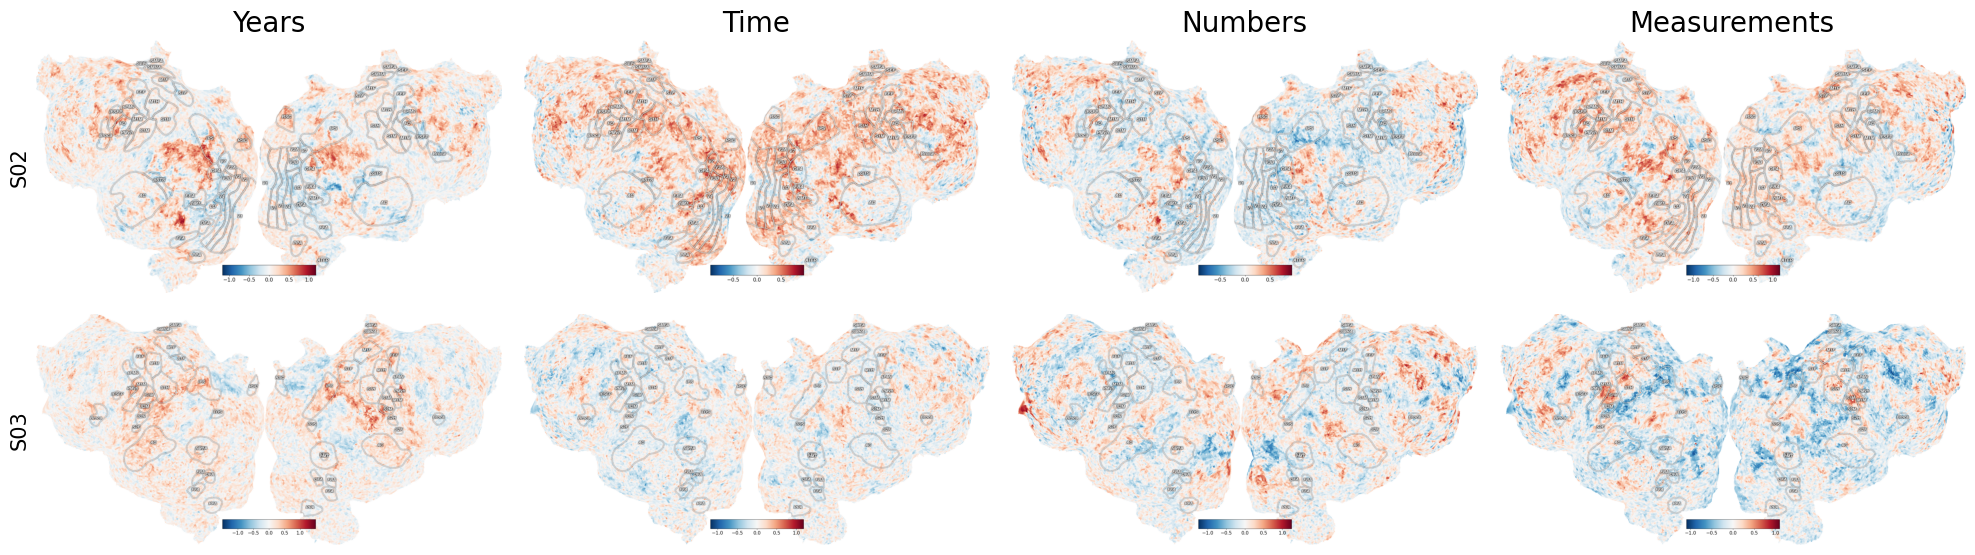

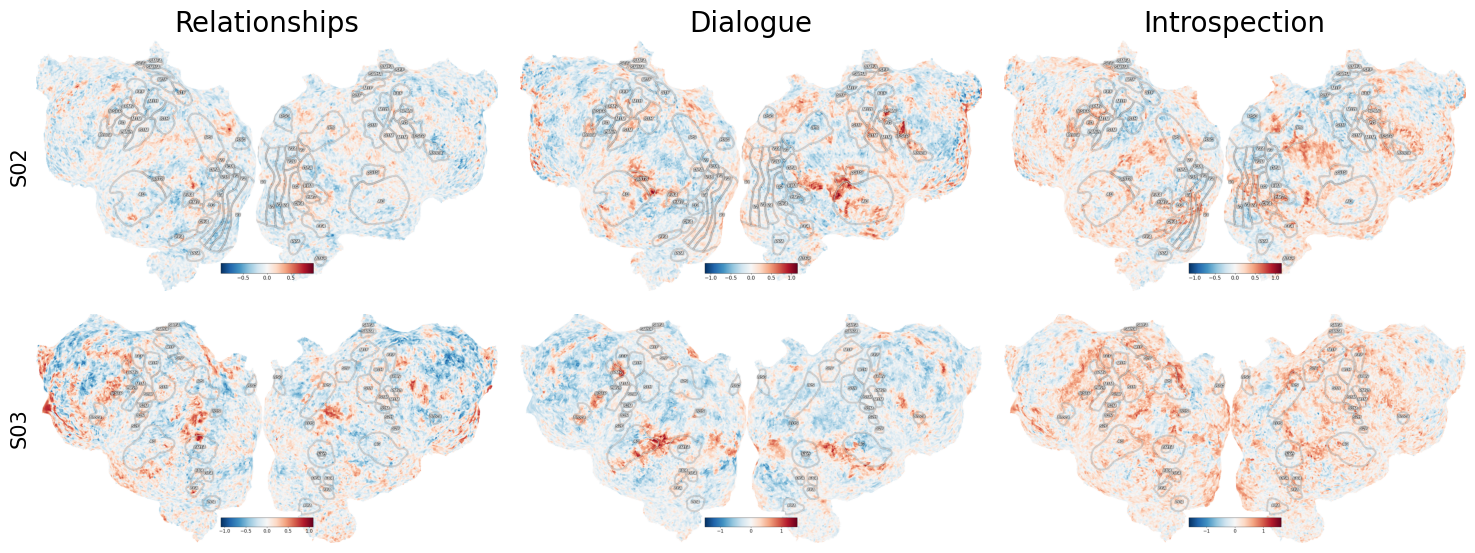

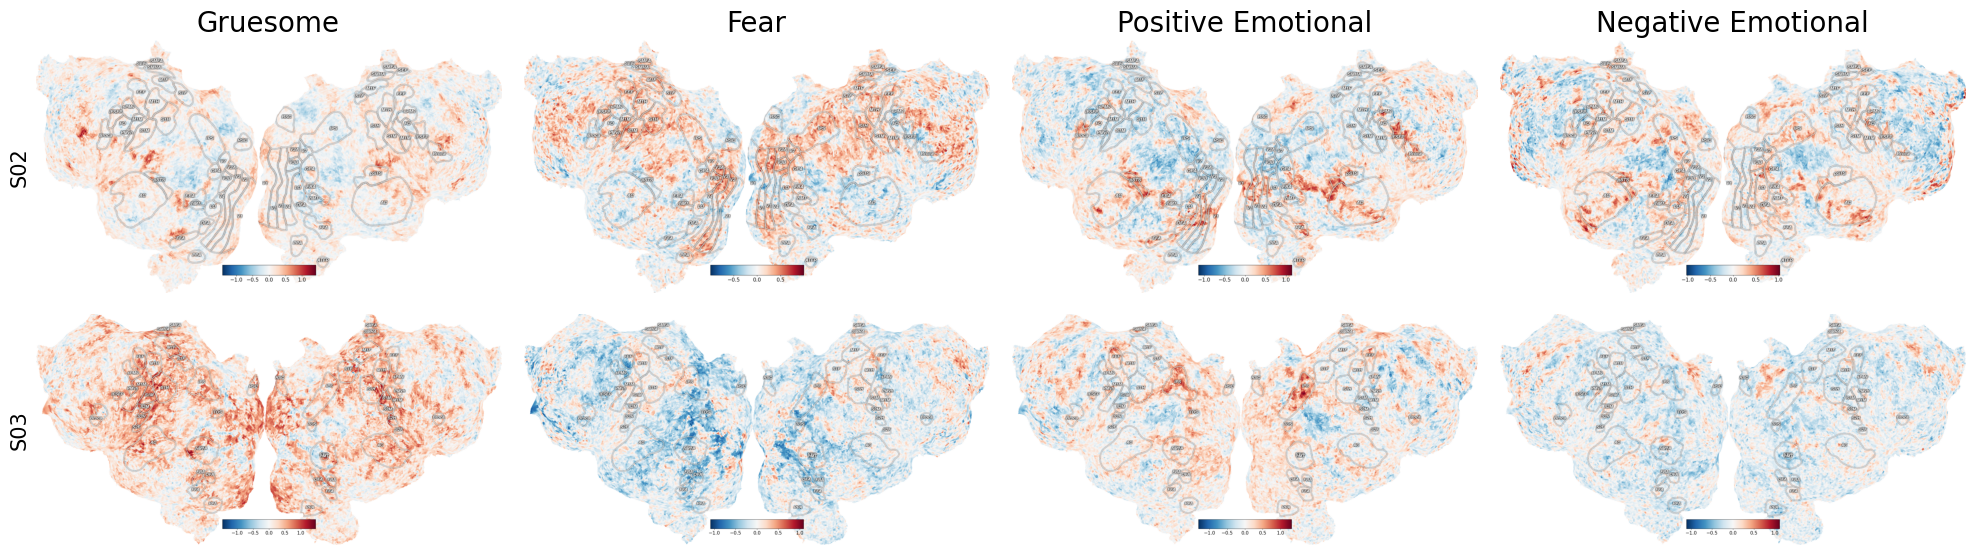

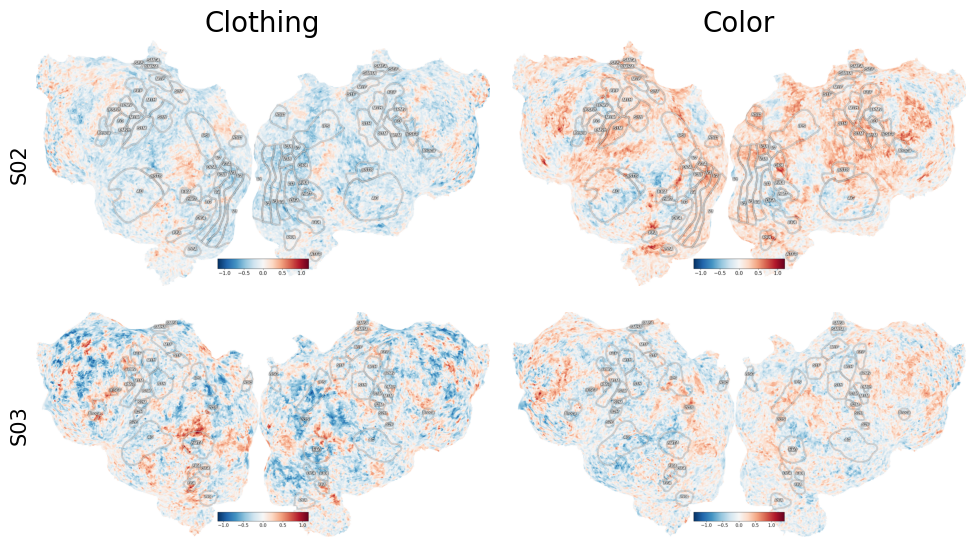

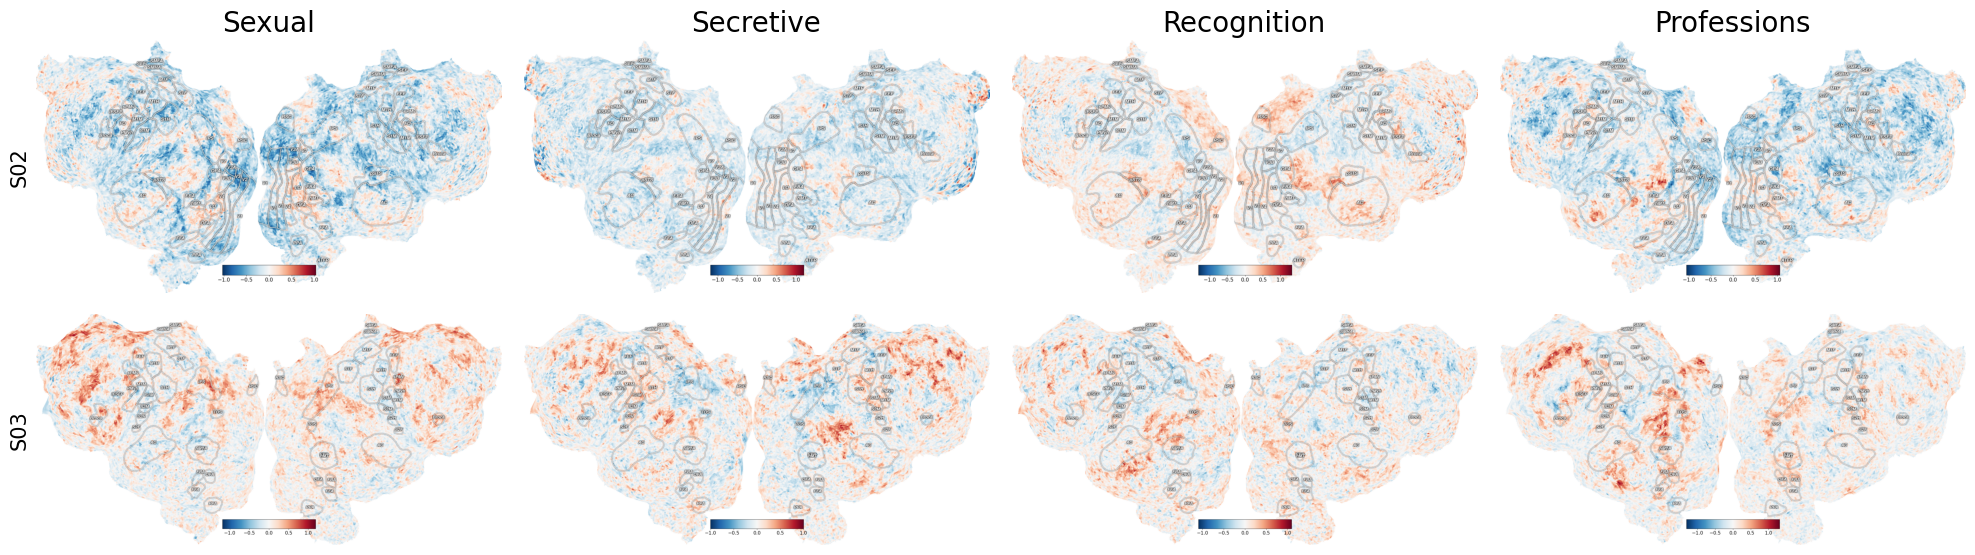

In [ ]:
# read a list of pngs and save them as a grid
for COMPARISONS in [
    ['Years', 'Time', 'Numbers', 'Measurements'],
    ['Relationships', 'Dialogue', 'Introspection'],
    ['Gruesome', 'Fear', 'Positive Emotional', 'Negative Emotional'],
    ['Clothing', 'Color'],
    ['Sexual', 'Secretive', 'Recognition', 'Professions']
]:

    pngs = defaultdict(list)
    for s in COMPARISONS:
        pngs['S02'] += [join(S02_flatmaps_dir, f)
                        for f in os.listdir(S02_flatmaps_dir) if f.endswith('.png') and s in f]
        pngs['S03'] += [join(S03_flatmaps_dir, f)
                        for f in os.listdir(S03_flatmaps_dir) if f.endswith('.png') and s in f]

    # plot as grid
    fig, axes = plt.subplots(
        2, len(COMPARISONS), figsize=(len(COMPARISONS) * 5, 6))
    for i, ax in enumerate(axes.flatten()):
        # ax.axis('off')
        # Remove all x-axis ticks and labels
        ax.xaxis.set_ticks([])
        ax.xaxis.set_ticklabels([])
        ax.xaxis.label.set_visible(False)

        # Remove all y-axis ticks and labels (but keep the y-axis label)
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])

        for spine in ax.spines.values():
            spine.set_visible(False)

    for i in range(len(COMPARISONS)):
        axes[0, i].imshow(plt.imread(pngs['S02'][i]))
        axes[0, i].set_title(COMPARISONS[i])
        axes[1, i].imshow(plt.imread(pngs['S03'][i]))
        axes[0, 0].set_ylabel('S02')
        axes[1, 0].set_ylabel('S03')

    # add
    plt.savefig('__'.join(COMPARISONS) + '.png', bbox_inches='tight', dpi=300)
    plt.show()